In [64]:
import numpy as np
import sympy
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt


class solver:
    def __init__(self, n_qubits):

        self.n_qubits=n_qubits
        self.qubits = cirq.GridQubit.rect(1, n_qubits)

        #observable = [-float(1/self.n_qubits)*cirq.Z.on(q)*cirq.Z.on(q) for q in qubits] 
        #for q in range(len(qubits)):
        #    observable.append(-float(0.5)*cirq.X.on(qubits[q])*cirq.X.on(qubits[(q+1)%len(qubits)]))

        #self.observable = observable
        
        self.indexed_cnots = {}
        self.cnots_index = {}
        count = 0
        for control in range(self.n_qubits):
            for target in range(self.n_qubits):
                if control != target:
                    self.indexed_cnots[str(count)] = [control, target]
                    self.cnots_index[str([control,target])] = count
                    count += 1
        self.number_of_cnots = len(self.indexed_cnots)
        self.parametrized_unitary = [cirq.rz, cirq.rx, cirq.rz]
        

    def append_to_circuit(self, ind, circuit, params, new_index=False):
        if ind < self.number_of_cnots:
            control, target = self.indexed_cnots[str(ind)]
            circuit.append(cirq.CNOT.on(self.qubits[control], self.qubits[target]))
            return circuit, params
        else:
            qubit = self.qubits[(ind-self.number_of_cnots)%self.n_qubits]
            for par, gate in zip(range(3),self.parametrized_unitary):
                new_param = "th_"+str(len(params))
                params.append(new_param)
                circuit.append(gate(sympy.Symbol(new_param)).on(qubit))
            return circuit, params

    def give_circuit(self, lista, one_hot=False):
        circuit, symbols = [], []
        for k in lista:
            circuit, symbols = self.append_to_circuit(k,circuit,symbols)
        circuit = cirq.Circuit(circuit)
        return circuit, symbols
    

    def cirq_friendly_observable(self, obs):
        PAULI_BASIS = {
            'I': np.eye(2),
            'X': np.array([[0., 1.], [1., 0.]]),
            'Y': np.array([[0., -1j], [1j, 0.]]),
            'Z': np.diag([1., -1]),
        }

        pauli3 = cirq.linalg.operator_spaces.kron_bases(PAULI_BASIS, repeat=self.n_qubits)
        decomp = cirq.linalg.operator_spaces.expand_matrix_in_orthogonal_basis(obs, pauli3)

        PAULI_BASIS_CIRQ = {
            'I': cirq.X,
            'X': cirq.X,
            'Y': cirq.Y,
            'Z': cirq.Z,
        }

        unt = []
        for term in decomp.items():
            gate_name = term[0]
            coeff = term[1]
            s = 0
            ot = float(coeff)
            for qpos, single_gate in enumerate(gate_name):
                if single_gate == "I":
                    ot *= PAULI_BASIS_CIRQ[single_gate](self.qubits[qpos])*PAULI_BASIS_CIRQ[single_gate](self.qubits[qpos])
                else:
                    ot *= PAULI_BASIS_CIRQ[single_gate](self.qubits[qpos])
            if s < 3:
                unt.append(ot)
        return unt


In [65]:
sol=solver(2)
circuit,symbols =sol.give_circuit([0,sol.number_of_cnots,sol.number_of_cnots+1,0])
circuit

(0, 0): ───@───Rz(th_0)───Rx(th_1)───Rz(th_2)───@───
           │                                    │
(0, 1): ───X───Rz(th_3)───Rx(th_4)───Rz(th_5)───X───

In [67]:
tfqcircuit = tfq.convert_to_tensor([circuit])

circuit_input = tf.keras.Input(shape=(), dtype=tf.string)

outps = tfq.layers.PQC(circuit,[cirq.Z(sol.qubits[0])*cirq.Z(sol.qubits[1])])



angles=[[0.,0.], [-np.pi,0.],[0.,-np.pi], [-np.pi,-np.pi]]
qdataset = [cirq.Circuit([cirq.ry(ang1)(sol.qubits[0]), cirq.ry(ang2)(sol.qubits[1])]) for ang1, ang2 in angles]
labs = [[1.,1.], [-1.,1.],[1.,-1.],[-1.,-1.]]

qdatasetx = [cirq.Circuit([cirq.rx(ang1)(sol.qubits[0]), cirq.rx(ang2)(sol.qubits[1])]) for ang1, ang2 in angles]
labsx = [[1.,1.], [1j,1.],[1.,1j],[1j,1j]]

qdatasetz = [cirq.Circuit([cirq.rz(ang1)(sol.qubits[0]), cirq.rz(ang2)(sol.qubits[1])]) for ang1, ang2 in angles]
labsz = [[1.,1.], [1j,1.],[1.,1j],[1j,1j]]

flabs = []
fdat = []
for q,l in zip(qdataset, labs):
    flabs.append(l)
    fdat.append(q)
for q,l in zip(qdatasetx, labsx):
    flabs.append(l)
    fdat.append(q)
#for q,l in zip(qdatasetz, labsz):
#    flabs.append(l)
#    fdat.append(q)
outps(tfq.convert_to_tensor(fdat))

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[ 0.9975756 ],
       [-0.9975757 ],
       [-0.9975756 ],
       [ 0.99757576],
       [ 0.9975756 ],
       [-0.9975757 ],
       [-0.9975756 ],
       [ 0.99757576]], dtype=float32)>

In [46]:
sim = cirq.Simulator()
[sim.simulate(c) for c in qdataset]
#[sim.simulate(cirq.resolve_parameters(circuit,res)) for k in range(4)]

[measurements: (no measurements)
output vector: |00⟩,
 measurements: (no measurements)
output vector: -1|10⟩,
 measurements: (no measurements)
output vector: -1|01⟩,
 measurements: (no measurements)
output vector: |11⟩]

In [57]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    outps,
])

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(lr=0.01))


In [58]:
history = model.fit(tfq.convert_to_tensor(fdat), tf.convert_to_tensor(np.array(flabs)),batch_size=1, epochs=500)

Train on 8 samples
Epoch 1/500
8/8 [==============================] - 1s 91ms/sample - loss: 1.3870
Epoch 2/500
8/8 [==============================] - 0s 5ms/sample - loss: 1.2891
Epoch 3/500
8/8 [==============================] - 0s 5ms/sample - loss: 1.1836
Epoch 4/500
8/8 [==============================] - 0s 5ms/sample - loss: 1.0725
Epoch 5/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.9707
Epoch 6/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.8798
Epoch 7/500
8/8 [==============================] - 0s 6ms/sample - loss: 0.7980
Epoch 8/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.7288
Epoch 9/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.6761
Epoch 10/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.6328
Epoch 11/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.5981
Epoch 12/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.5696
Epoch 13/500
8/8 

Epoch 102/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.1891
Epoch 103/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.1894
Epoch 104/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.1890
Epoch 105/500
8/8 [==============================] - 0s 6ms/sample - loss: 0.1894
Epoch 106/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1892
Epoch 107/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1896
Epoch 108/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1889
Epoch 109/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1890
Epoch 110/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1894
Epoch 111/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.1889
Epoch 112/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1892
Epoch 113/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1892
Epoch 114/500
8/

8/8 [==============================] - 0s 5ms/sample - loss: 0.1883
Epoch 202/500
8/8 [==============================] - 0s 6ms/sample - loss: 0.1892
Epoch 203/500
8/8 [==============================] - 0s 6ms/sample - loss: 0.1880
Epoch 204/500
8/8 [==============================] - 0s 7ms/sample - loss: 0.1884
Epoch 205/500
8/8 [==============================] - 0s 7ms/sample - loss: 0.1879
Epoch 206/500
8/8 [==============================] - 0s 6ms/sample - loss: 0.1881
Epoch 207/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.1890
Epoch 208/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.1896
Epoch 209/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.1890
Epoch 210/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.1879
Epoch 211/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.1888
Epoch 212/500
8/8 [==============================] - 0s 6ms/sample - loss: 0.1883
Epoch 213/500
8/8 [===========

8/8 [==============================] - 0s 5ms/sample - loss: 0.1878
Epoch 302/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1880
Epoch 303/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1882
Epoch 304/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1884
Epoch 305/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1903
Epoch 306/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1884
Epoch 307/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1878
Epoch 308/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1883
Epoch 309/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1880
Epoch 310/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1880
Epoch 311/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1880
Epoch 312/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1880
Epoch 313/500
8/8 [===========

8/8 [==============================] - 0s 5ms/sample - loss: 0.1887
Epoch 402/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1884
Epoch 403/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.1882
Epoch 404/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1886
Epoch 405/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.1879
Epoch 406/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1880
Epoch 407/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1877
Epoch 408/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1882
Epoch 409/500
8/8 [==============================] - 0s 5ms/sample - loss: 0.1877
Epoch 410/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1883
Epoch 411/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1878
Epoch 412/500
8/8 [==============================] - 0s 4ms/sample - loss: 0.1879
Epoch 413/500
8/8 [===========

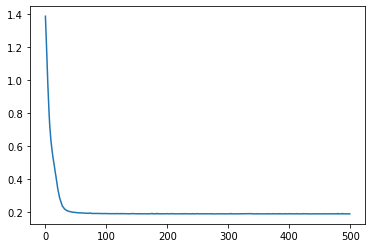

In [59]:
plt.plot(history.history["loss"])

In [60]:
model.trainable_variables

[<tf.Variable 'parameters:0' shape=(6,) dtype=float32, numpy=
 array([2.2637982 , 0.72606444, 2.835845  , 4.1100154 , 0.1128982 ,
        1.3224062 ], dtype=float32)>]

In [61]:
res={sy:j for sy,j in zip(symbols,model.trainable_variables[0].numpy())}

In [62]:
np.round(cirq.unitary(cirq.resolve_parameters(circuit,res)),4)

array([[ 0.4907+0.7939j, -0.0483-0.0213j, -0.0089-0.0179j,
        -0.0492+0.3511j],
       [ 0.0379+0.0367j,  0.9204+0.1546j,  0.2315+0.2685j,
         0.0022+0.0199j],
       [-0.0089+0.0179j,  0.0492+0.3511j,  0.4907-0.7939j,
         0.0483-0.0213j],
       [-0.2315+0.2685j,  0.0022-0.0199j, -0.0379+0.0367j,
         0.9204-0.1546j]])

In [63]:
model.predict(tfq.convert_to_tensor(fdat))

array([[ 0.74779314,  0.7430325 ],
       [-0.7477932 ,  0.7430326 ],
       [ 0.74779326, -0.74303263],
       [-0.74779314, -0.7430325 ],
       [ 0.74779314,  0.7430325 ],
       [-0.7477932 ,  0.7430326 ],
       [ 0.74779326, -0.74303263],
       [-0.74779314, -0.7430325 ]], dtype=float32)

In [20]:
np.dot(np.round(cirq.unitary(cirq.resolve_parameters(circuit,res)),4),np.array([1,0,0,0]))

array([-0.213 +9.723e-01j,  0.0003-2.000e-04j,  0.    +0.000e+00j,
       -0.0865-4.190e-02j])